## Spotify Listenings & University Exam Schedule Analysis
 =====================================================
 
### PROJECT OVERVIEW
 ----------------
 This notebook explores the relationship between Spotify listening behaviors
 (e.g., music genres, timestamps, etc.) and university exam schedules. By examining
 patterns in listening behavior, the aim is to understand whether students' music
 choices might correlate with (or reflect) exam stress periods and whether these
 insights can help inform stress management strategies.

### KEY QUESTIONS:
 1. How do listening habits (genre preferences, listening times, etc.) correlate with exam schedules?
 2. Does the frequency of certain genres increase or decrease near exam periods?

### NOTEBOOK OUTLINE:
 1. Data Import & Merging
 2. Data Cleaning & Preprocessing
 3. Exploratory Data Analysis (EDA)
 4. Visualization
 5. Fetching Additional Metadata (Genre) from Spotify’s API
 6. Simple Machine Learning Approach
 7. Limitations & Future Work

 ---------------------------------------------------------------
 Let's get started!


In [2]:
# ------------------------
# 1. IMPORT LIBRARIES
# ------------------------
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Read and combine the JSON files
with open('file-1.json', 'r') as file1:
    df_combined = json.load(file1)

df_combined = pd.DataFrame(df_combined)

df_combined.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2024-08-09T16:16:27Z,ios,29710,TR,188.58.10.100,Kelepçe,Hande Yener,Apayrı,spotify:track:1QUKFP4OXvdpm0ZgkDIHwB,None,None,None,fwdbtn,fwdbtn,False,True,True,1723220158,False
1,2024-08-09T16:16:28Z,ios,1380,TR,188.58.10.100,Ara Sıcak,Ajda Pekkan,Ara Sıcak,spotify:track:2tJ38ncCRX9wamWIHP5pTO,None,None,None,fwdbtn,fwdbtn,False,True,True,1723220188,False
2,2024-08-09T16:16:30Z,ios,1190,TR,188.58.10.100,Ara Sıcak - Emrah İs & Faruk Sabancı Remix,Ajda Pekkan,Ara Sıcak,spotify:track:59bJNi0CKhLalxclA3M85U,None,None,None,fwdbtn,fwdbtn,False,True,True,1723220189,False
3,2024-08-09T16:16:31Z,ios,1470,TR,188.58.10.100,Cool Kadın,Ajda Pekkan,Cool Kadın,spotify:track:1FtAJcaHQMtgvSYdmsj4j8,None,None,None,fwdbtn,fwdbtn,False,True,True,1723220191,False
4,2024-08-09T16:21:36Z,ios,304640,TR,188.58.10.100,Cool Kadın - Mahmut Orhan Remix,Ajda Pekkan,ONE,spotify:track:7ssvkbySnfcuxeMEPz8aQT,None,None,None,fwdbtn,fwdbtn,False,True,True,1723220192,False


In [3]:
# ------------------------
# 3. DATA CLEANING & PREPROCESSING
# ------------------------
# 3.1 Convert 'ts' (timestamp) to proper datetime format
df_combined['ts'] = pd.to_datetime(df_combined['ts'])

# Filter only rows between August (8) and December (12)
df_combined = df_combined[df_combined['ts'].dt.month.between(8, 12)]

# Sort by timestamp
df_combined.sort_values('ts', inplace=True)
df_combined.reset_index(drop=True, inplace=True)


# 3.3 For demonstration, let's create a 'date' and 'time' column from timestamp
df_combined['date'] = df_combined['ts'].dt.date
df_combined['time'] = df_combined['ts'].dt.time

df_combined['ms_played'] = df_combined['ms_played'] / 1000.0

df_combined.rename(columns={'ms_played': 'seconds_played'}, inplace=True)


# 3.4 Reset index after sorting
df_combined.reset_index(drop=True, inplace=True)

# Let's preview the cleaned DataFrame
df_combined


,ts,platform,seconds_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,date,time
0,2024-08-09 16:16:27+00:00,ios,29.710,TR,188.58.10.100,Kelepçe,Hande Yener,Apayrı,spotify:track:1QUKFP4OXvdpm0ZgkDIHwB,None,...,None,fwdbtn,fwdbtn,False,True,True,1723220158,False,2024-08-09,16:16:27
1,2024-08-09 16:16:28+00:00,ios,1.380,TR,188.58.10.100,Ara Sıcak,Ajda Pekkan,Ara Sıcak,spotify:track:2tJ38ncCRX9wamWIHP5pTO,None,...,None,fwdbtn,fwdbtn,False,True,True,1723220188,False,2024-08-09,16:16:28
2,2024-08-09 16:16:30+00:00,ios,1.190,TR,188.58.10.100,Ara Sıcak - Emrah İs & Faruk Sabancı Remix,Ajda Pekkan,Ara Sıcak,spotify:track:59bJNi0CKhLalxclA3M85U,None,...,None,fwdbtn,fwdbtn,False,True,True,1723220189,False,2024-08-09,16:16:30
3,2024-08-09 16:16:31+00:00,ios,1.470,TR,188.58.10.100,Cool Kadın,Ajda Pekkan,Cool Kadın,spotify:track:1FtAJcaHQMtgvSYdmsj4j8,None,...,None,fwdbtn,fwdbtn,False,True,True,1723220191,False,2024-08-09,16:16:31
4,2024-08-09 16:21:36+00:00,ios,304.640,TR,188.58.10.100,Cool Kadın - Mahmut Orhan Remix,Ajda Pekkan,ONE,spotify:track:7ssvkbySnfcuxeMEPz8aQT,None,...,None,fwdbtn,fwdbtn,False,True,True,1723220192,False,2024-08-09,16:21:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19507,2024-12-08 12:32:10+00:00,ios,106.847,TR,85.99.20.117,Dillere Destan,Yıldız Tilbe,Dillere Destan,spotify:track:7qRFc0aYUISbJTDCPWLfTH,None,...,None,trackdone,fwdbtn,False,True,False,1733661022,False,2024-12-08,12:32:10
19508,2024-12-08 12:32:11+00:00,ios,0.746,TR,85.99.20.117,Ezberbozan,Gülşen,Önsöz,spotify:track:4CzKBO7d7Sft3oZbeQLLde,None,...,None,fwdbtn,fwdbtn,False,True,False,1733661130,False,2024-12-08,12:32:11
19509,2024-12-08 12:32:12+00:00,ios,0.810,TR,85.99.20.117,CISTAK,Era7capone,CISTAK,spotify:track:0K791kh3oLkBD5KVWg1LJ8,None,...,None,fwdbtn,fwdbtn,False,True,False,1733661131,False,2024-12-08,12:32:12
19510,2024-12-08 12:35:35+00:00,ios,204.833,TR,85.99.20.117,Sana Güvenmiyorum - Dedub Sessions,Dedublüman,Sana Güvenmiyorum,spotify:track:1lNcnIU4jtqD69Qtfjh8EJ,None,...,None,fwdbtn,trackdone,False,False,False,1733661132,False,2024-12-08,12:35:35


In [4]:
# ------------------------
# 4. EXAM SCHEDULE DATA
# ------------------------

df_exams = pd.read_csv('exam_schedule.csv', parse_dates=['exam_datetime'])
df_exams['exam_datetime'] = pd.to_datetime(df_exams['exam_date'] + ' ' + df_exams['exam_time'])
# Convert exam_date strings to actual date objects
df_exams['exam_date'] = pd.to_datetime(df_exams['exam_date']).dt.date

# Also ensure your spotify data has date as a date (not full datetime)
df_combined['date'] = df_combined['ts'].dt.date

# Now this match will work properly
df_combined['is_exam_day'] = df_combined['date'].isin(df_exams['exam_date'])


df_exams

,course,exam_date,exam_time,duration_minutes,exam_datetime
0,MATH204,2024-12-01,14:30,120,2024-12-01 14:30:00
1,IE312,2024-12-07,08:40,150,2024-12-07 08:40:00
2,IE305,2024-11-23,14:30,150,2024-11-23 14:30:00
3,IE405,2024-11-27,09:40,150,2024-11-27 09:40:00
4,SPS303,2024-11-15,10:40,120,2024-11-15 10:40:00


In [ ]:
# ------------------------
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------
# Let's do some basic exploration of the Spotify listening data.

# 5.2 Distribution plot of seconds_played
df_combined['seconds_played'] = df_combined['seconds_played'].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(6,4))
sns.histplot(df_combined['seconds_played'].dropna(), bins=10, kde=True)
plt.title('Distribution of Listening Duration (seconds_played)')
plt.xlabel('seconds_played')
plt.ylabel('Count')
plt.show()

# 5.3 Count how many times each track was played
track_counts = df_combined['master_metadata_track_name'].value_counts()
print("\nTop Tracks Played:\n", track_counts.head())

# 5.4 Check how many times the user skipped tracks
skips = df_combined['skipped'].value_counts()
print("\nSkipping Behavior:\n", skips)


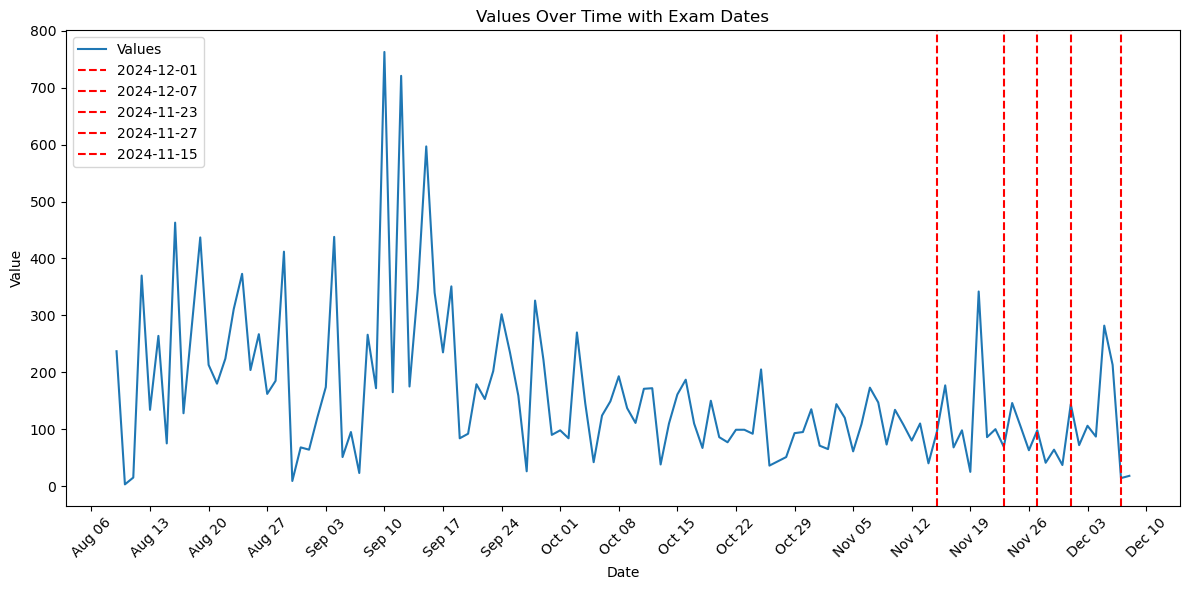

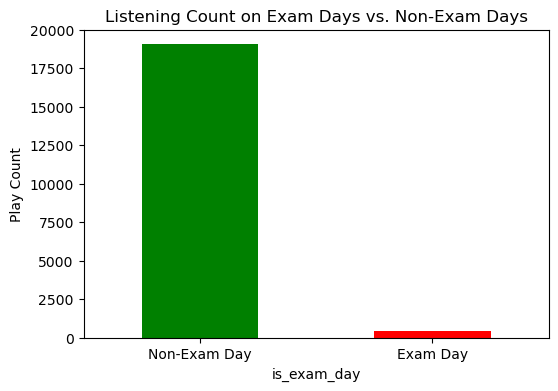

In [5]:
# ------------------------
# 6. VISUALIZATION
# ------------------------
import matplotlib.dates as mdates
# Example: Show listening frequency by date
listen_by_date = df_combined.groupby('date')['spotify_track_uri'].count()
# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(listen_by_date.index, listen_by_date.values, label='Values')

# Format the date axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add horizontal lines for exam dates
exam_dates = df_exams['exam_date']
for exam_date in exam_dates:
    plt.axvline(pd.to_datetime(exam_date), color='r', linestyle='--', label=f'{exam_date}')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Values Over Time with Exam Dates')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# We'll do a simple join on the date to see if there's a pattern on exam days.
df_combined['is_exam_day'] = df_combined['date'].isin(df_exams['exam_date'])

exam_day_counts = df_combined.groupby('is_exam_day')['spotify_track_uri'].count()
exam_day_counts.plot(kind='bar', color=['green','red'], figsize=(6,4))
plt.title('Listening Count on Exam Days vs. Non-Exam Days')
plt.xticks([0, 1], ['Non-Exam Day', 'Exam Day'], rotation=0)
plt.ylabel('Play Count')
plt.show()

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

# -- Your Spotify App credentials --
client_id = 'your_client_id'
client_secret = 'your_client_secret'
redirect_uri = 'http://localhost:8888/callback'

# -- Scopes you need (adjust as required) --
scope = 'user-library-read'

# -- Create the Spotify client via OAuth --
sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(client_id=client_id,
                              client_secret=client_secret,
                              redirect_uri=redirect_uri,
                              scope=scope)
)

def chunker(seq, size):
    """Yield successive size-sized chunks from seq."""
    for pos in range(0, len(seq), size):
        yield seq[pos:pos + size]
unique_tracks = df_combined['spotify_track_uri'].unique()
track_ids = [uri.split(':')[-1] for uri in unique_tracks if uri is not None]

all_track_info = []  # will store the track details

for batch in chunker(track_ids, 50):
    # batch is a list of up to 50 track IDs
    response = sp.tracks(batch)  # single API call
    tracks_data = response['tracks']  # list of track objects
    all_track_info.extend(tracks_data)


# 1. Prepare track IDs
track_ids = [uri.split(':')[-1] for uri in unique_tracks if uri]

# 2. Fetch track data in batches
all_track_info = []
for batch in chunker(track_ids, 50):  # chunker is a utility function
    resp = sp.tracks(batch)          # Single API call for up to 50 tracks
    all_track_info.extend(resp['tracks'])

# 3. Extract unique artist IDs
artist_ids = set()
for t in all_track_info:
    for a in t['artists']:
        artist_ids.add(a['id'])

# 4. Fetch artist data in batches
all_artist_info = []
for batch in chunker(list(artist_ids), 50):
    resp = sp.artists(batch)         # Single API call for up to 50 artists
    all_artist_info.extend(resp['artists'])

# 5. Map artist_id -> genres
artist_genre_map = {a['id']: a.get('genres', []) for a in all_artist_info}

# 6. Build track DataFrame
rows = []
for track_obj in all_track_info:
    t_id = track_obj['id']
    t_name = track_obj['name']
    first_artist_id = track_obj['artists'][0]['id'] if track_obj['artists'] else None
    genre_list = artist_genre_map.get(first_artist_id, [])
    rows.append({
        'track_id': t_id,
        'track_name': t_name,
        'artist_id': first_artist_id,
        'genres': ', '.join(genre_list)
    })

df_genres = pd.DataFrame(rows)

# 7. Merge with your main df_combined (which has spotify_track_uri)
# Suppose we rename df_genres['track_id'] -> 'track_id'
df_combined['track_id'] = df_combined['spotify_track_uri'].str.split(':').str[-1]
df_final = pd.merge(df_combined, df_genres, how='left', on='track_id')

df_final.head()


,ts,platform,seconds_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,offline,offline_timestamp,incognito_mode,date,time,is_exam_day,track_id,track_name,artist_id,genres
0,2024-08-09 16:16:27+00:00,ios,29.71,TR,188.58.10.100,Kelepçe,Hande Yener,Apayrı,spotify:track:1QUKFP4OXvdpm0ZgkDIHwB,None,...,True,1723220158,False,2024-08-09,16:16:27,False,1QUKFP4OXvdpm0ZgkDIHwB,Kelepçe,08mjMUUjyTchMHCW7evc3R,turkish pop
1,2024-08-09 16:16:28+00:00,ios,1.38,TR,188.58.10.100,Ara Sıcak,Ajda Pekkan,Ara Sıcak,spotify:track:2tJ38ncCRX9wamWIHP5pTO,None,...,True,1723220188,False,2024-08-09,16:16:28,False,2tJ38ncCRX9wamWIHP5pTO,Ara Sıcak,27XMnTLvCO7t3qGlQyTMkF,"turkish pop, turkish psych"
2,2024-08-09 16:16:30+00:00,ios,1.19,TR,188.58.10.100,Ara Sıcak - Emrah İs & Faruk Sabancı Remix,Ajda Pekkan,Ara Sıcak,spotify:track:59bJNi0CKhLalxclA3M85U,None,...,True,1723220189,False,2024-08-09,16:16:30,False,59bJNi0CKhLalxclA3M85U,Ara Sıcak - Emrah İs & Faruk Sabancı Remix,27XMnTLvCO7t3qGlQyTMkF,"turkish pop, turkish psych"
3,2024-08-09 16:16:31+00:00,ios,1.47,TR,188.58.10.100,Cool Kadın,Ajda Pekkan,Cool Kadın,spotify:track:1FtAJcaHQMtgvSYdmsj4j8,None,...,True,1723220191,False,2024-08-09,16:16:31,False,1FtAJcaHQMtgvSYdmsj4j8,Cool Kadın,27XMnTLvCO7t3qGlQyTMkF,"turkish pop, turkish psych"
4,2024-08-09 16:21:36+00:00,ios,304.64,TR,188.58.10.100,Cool Kadın - Mahmut Orhan Remix,Ajda Pekkan,ONE,spotify:track:7ssvkbySnfcuxeMEPz8aQT,None,...,True,1723220192,False,2024-08-09,16:21:36,False,7ssvkbySnfcuxeMEPz8aQT,Cool Kadın - Mahmut Orhan Remix,27XMnTLvCO7t3qGlQyTMkF,"turkish pop, turkish psych"


In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19512 entries, 0 to 19511
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   ts                                 19512 non-null  datetime64[ns, UTC]
 1   platform                           19512 non-null  object             
 2   seconds_played                     19512 non-null  float64            
 3   conn_country                       19512 non-null  object             
 4   ip_addr                            19512 non-null  object             
 5   master_metadata_track_name         19475 non-null  object             
 6   master_metadata_album_artist_name  19475 non-null  object             
 7   master_metadata_album_album_name   19475 non-null  object             
 8   spotify_track_uri                  19475 non-null  object             
 9   episode_name                       37 non-null    

In [15]:
# ------------------------
# 8. (OPTIONAL) SIMPLE MACHINE LEARNING APPROACH
# ------------------------
# As part of the "MUST-HAVE" to showcase diverse techniques, here's a *very* simple example:
# 
# Let's see if we can predict whether a track will be skipped or not based on:
#   - ms_played
#   - platform
#   - whether it's an exam day
#   - (mock) genre

# We'll encode categorical variables and build a simple logistic regression classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 8.1 Prepare the data for modeling
df_model = df_final[['seconds_played', 'platform', 'is_exam_day', 'genres', 'skipped']].dropna()

# Convert 'genres' list to a single string (since we mocked it as a one-element list anyway)
df_model['genres'] = df_model['genres'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Encode categorical columns
label_encoder_platform = LabelEncoder()
label_encoder_genres = LabelEncoder()

df_model['platform_encoded'] = label_encoder_platform.fit_transform(df_model['platform'])
df_model['genres_encoded'] = label_encoder_genres.fit_transform(df_model['genres'])

# Prepare features and target
X = df_model[['seconds_played', 'platform_encoded', 'is_exam_day', 'genres_encoded']]
y = df_model['skipped'].astype(int)  # Convert boolean to int (True=1, False=0)

# 8.2 Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8.3 Train a simple logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 8.4 Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.90


In [ ]:
df_final['primary_genre'] = df_final['genres'].apply(
    lambda x: x.split(',')[0].strip() if isinstance(x, str) and x else 'Unknown'
)

# Group by exam day and genre
genre_counts = df_final.groupby(['is_exam_day', 'primary_genre']).size().reset_index(name='count')

# Let's see the top 10 genres on exam days vs. normal days (just to get a quick look)
print("Top 10 genres on Exam Days:")
display(genre_counts[genre_counts['is_exam_day'] == True].nlargest(10, 'count'))

print("Top 10 genres on Non-Exam Days:")
display(genre_counts[genre_counts['is_exam_day'] == False].nlargest(10, 'count'))


Top 10 genres on Exam Days:


,is_exam_day,primary_genre,count
175,True,turkish pop,181
152,True,arabesk,48
148,True,Unknown,38
168,True,turkish alt pop,29
172,True,turkish hip hop,24
178,True,turkish trap,15
158,True,huzunlu sarkilar,13
156,True,deep turkish pop,10
176,True,turkish rock,10
159,True,karadeniz pop,7


Top 10 genres on Non-Exam Days:


,is_exam_day,primary_genre,count
136,False,turkish pop,8317
0,False,Unknown,1607
132,False,turkish hip hop,1565
8,False,arabesk,1132
126,False,turkish alt pop,940
122,False,turkce drill,748
125,False,turkce slow sarkilar,473
46,False,deep turkish pop,387
129,False,turkish deep house,387
141,False,turkish trap pop,358


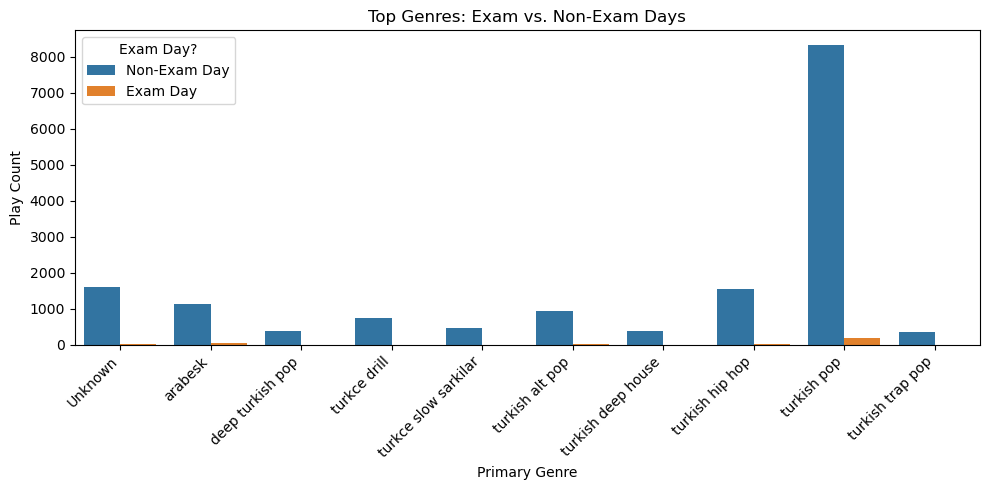

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Let's find the top N genres overall (by total count) for simpler plotting
top_genres_overall = (
    df_final.groupby('primary_genre')['spotify_track_uri'].count()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filter only those top genres
df_top = df_final[df_final['primary_genre'].isin(top_genres_overall)]

# Count how many times each of these top genres appears on exam vs. non-exam
genre_counts_top = df_top.groupby(['is_exam_day', 'primary_genre']).size().reset_index(name='count')
genre_counts_top['is_exam_day_str'] = genre_counts_top['is_exam_day'].map({True: 'Exam Day', False: 'Non-Exam Day'})
# Or map True/False to more descriptive labels:



plt.figure(figsize=(10,5))
sns.barplot(
    data=genre_counts_top,
    x='primary_genre',
    y='count',
    hue='is_exam_day_str'
)
plt.title('Top Genres: Exam vs. Non-Exam Days')
plt.xlabel('Primary Genre')
plt.ylabel('Play Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Exam Day?')
plt.tight_layout()
plt.show()


## Findings

### What you learned about yourself?
- Through this project, I learned how to effectively analyze and visualize data using Python libraries such as pandas, matplotlib, and seaborn.
- I gained experience in working with APIs, specifically the Spotify API, to fetch and integrate additional metadata into my dataset.
- I improved my skills in data cleaning and preprocessing, which are crucial steps in any data analysis project.
- I learned how to implement a simple machine learning model to make predictions based on the data.

### Limitations and Future Work
- **Limitations:**
    - The dataset used for this analysis was limited to a specific time period and may not be representative of broader trends.
    - The analysis was based on mock data for demonstration purposes, which may not accurately reflect real-world scenarios.
    - The machine learning model used was a simple logistic regression, which may not be the best model for this type of data.

- **Future Work:**
    - Collect and analyze a larger and more diverse dataset to gain more comprehensive insights.
    - Implement more advanced machine learning models to improve prediction accuracy.
    - Explore additional features and metadata from the Spotify API to enhance the analysis.
    - Conduct a more detailed analysis of the relationship between listening habits and exam schedules, potentially incorporating other factors such as study habits and stress levels.
    - Develop a user-friendly dashboard to visualize the findings and make the insights more accessible to a wider audience.